In [ ]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import gseapy as gp

import matplotlib.pyplot as plt
import seaborn as sns

import sccoda.util.data_generation as gen
import sccoda.util.comp_ana as mod

import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/03_batch_expression/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/Users/jessica/Desktop/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/03_abundance_change"

In [5]:
# load cd4 annotations
cd4 = sc.read_h5ad("/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/02_cd4_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_cd4_scVI_annot_tfh.h5ad")

cd4.obs['cell_type'].unique()
cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    8057
Tfh / cTfh                          806
Th17-like memory CD4 T cell         424
Regulatory T cell                   267
Cycling CD4 T cell                  239
CCR6+ memory CD4 T cell             222
Cytotoxic CD4 T cell                 43
T stem-cell memory CD4 T cell         1
Name: count, dtype: int64

In [10]:
annot = sc.read_h5ad("/Users/jessica/Desktop/GitHub/Jessica_notebooks/data/batch_integration_1-3_nk_t_subset.h5ad")

annot.obs['cell_type'].unique()
annot.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell      146572
Cytotoxic NK cell                     67398
Naive/Central memory CD8 T cell       53031
Gamma-delta T cell                    34979
CCR4+ CCR6+ memory CD4 T cell         33058
TIGIT+ TOX+ memory CD4 T cell         16359
CCR6+ memory CD4 T cell               15790
MAIT                                  14464
Treg                                  13752
DN gdT cell                           12665
TOX+ CD8 T cell                       10989
CD27- CCR7- suppressed CD8 T cell      9906
CD8+ gdT cell                          8854
NKT                                    7889
NK-like gamma-delta T cell             6846
Cytotoxic natural killer cell          5964
CD27+ CCR7+ suppressed CD8 T cell      5363
CD27+ CCR7- suppressed CD8 T cell      4888
GZMK+ CD8 T cell                       3594
Cytokine-producing NK cell             3291
CCR4+ memory CD4 T cell                2203
Cytotoxic CD4 T cell                   1207
Innate-like CD4 T cell

In [ ]:
annot_copy = annot.copy()
cd4_copy   = cd4.copy()

annot_copy.obs_names = annot_copy.obs_names.astype(str)
cd4_copy.obs_names   = cd4_copy.obs_names.astype(str)

annot_copy.obs["dataset_source"] = "annot_T_NK"
cd4_copy.obs["dataset_source"]   = "annot_CD4_TFH"

In [ ]:
combined = sc.concat(
    [annot_copy, cd4_copy],
    join="outer",
    label="origin",                             
    keys=["annot_T_NK", "annot_CD4_TFH"],  
    index_unique=None
)

In [ ]:
print(combined.obs["origin"].value_counts())
print(combined.obs["cell_type"].value_counts())

In [ ]:
combined.write_h5ad("/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_03_combined_T_NK_CD4.h5ad", compression="gzip")


In [ ]:
adata = sc.read_h5ad("/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_03_combined_T_NK_CD4.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 492612 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', 'dataset_source', '_scvi_batch', '_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1', 'origin'
    uns: 'cell_type_colors', 'origin_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'c

In [ ]:
adata.obs['cell_type'].unique()
adata.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell      154816
Cytotoxic NK cell                     67398
Naive/Central memory CD8 T cell       53031
Gamma-delta T cell                    34979
CCR4+ CCR6+ memory CD4 T cell         33058
TIGIT+ TOX+ memory CD4 T cell         16359
CCR6+ memory CD4 T cell               16011
MAIT                                  14464
Treg                                  13752
DN gdT cell                           12665
TOX+ CD8 T cell                       10989
CD27- CCR7- suppressed CD8 T cell      9906
CD8+ gdT cell                          8854
NKT                                    7889
NK-like gamma-delta T cell             6846
Cytotoxic natural killer cell          5964
CD27+ CCR7+ suppressed CD8 T cell      5363
CD27+ CCR7- suppressed CD8 T cell      4888
GZMK+ CD8 T cell                       3594
Cytokine-producing NK cell             3291
CCR4+ memory CD4 T cell                2203
Cytotoxic CD4 T cell                   1250
Tfh / cTfh            

In [ ]:
# load metadata
meta = pd.read_csv("/Users/jessica/Desktop/GitHub/Jessica_notebooks/data/PICA-PICAReportOverall_DATA_LABELS_2025-07-25_1224.csv", index_col=0)

# adjust index to match adata
meta.index = ["PICA" + str(i).zfill(4) for i in meta.index]


In [ ]:
# restrict meta to only those in adata
adata_picas = adata.obs["pica_id"].unique()
meta_sub = meta.loc[meta.index.isin(adata_picas)]

print(f"Metadata before: {meta.shape[0]} rows")
print(f"Metadata after subsetting: {meta_sub.shape[0]} rows")

Metadata before: 273 rows

Metadata after subsetting: 53 rows

In [ ]:
# join metadata to adata
adata_with_meta = adata.copy()

adata_with_meta.obs["pica_id"] = adata_with_meta.obs["pica_id"].astype("string")
adata_with_meta.obs = adata_with_meta.obs.join(meta_sub, on="pica_id", how="left", rsuffix="_meta")

In [ ]:
meta_summary = (
    adata_with_meta.obs[["pica_id", "Child's sex", "Age in years at the time of collection"]]
    .drop_duplicates()
    .sort_values("pica_id")
)
print(meta_summary)

pica_id Child's sex  \
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0001        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0002        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0003        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0004        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0005        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0006        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0007        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0008      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0009      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0010      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0011        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0012      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0013        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0014        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0015        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0016        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0017        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0018      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0019        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0020        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0022        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0023        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0024      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0025        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0028      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0029      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0030      Female   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0031        Male   
20240918_WGS_20240924_sc_PICA0008-PICA0032_2024...  PICA0032        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0033      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0034      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0035        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0036        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0037      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0039      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0040        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0043        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0044      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0046      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0047        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0048        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0049      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0050      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0051        Male   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0052      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0055      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0056      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0057      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0059      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0061      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0063      Female   
20241106_WGS_20241106_sc_PICA0033-PICA0069_2024...  PICA0065        Male   
20241106_WGS_20241106_sc_

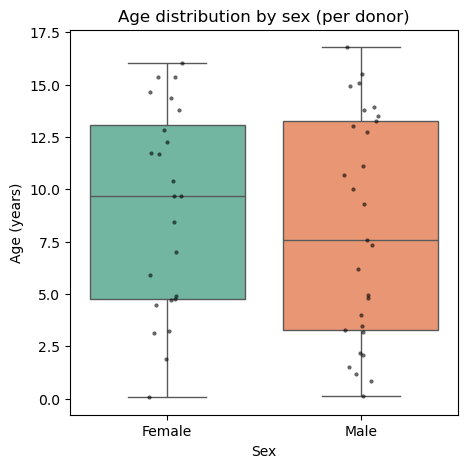

In [ ]:
meta_df = adata_with_meta.obs[['pica_id', "Child's sex", "Age in years at the time of collection"]].drop_duplicates()

plt.figure(figsize=(5,5))
sns.boxplot(data=meta_df, x="Child's sex", y="Age in years at the time of collection", palette="Set2")
sns.stripplot(data=meta_df, x="Child's sex", y="Age in years at the time of collection", color="k", size=3, alpha=0.6)
plt.title("Age distribution by sex (per donor)")
plt.ylabel("Age (years)")
plt.xlabel("Sex")
plt.show()

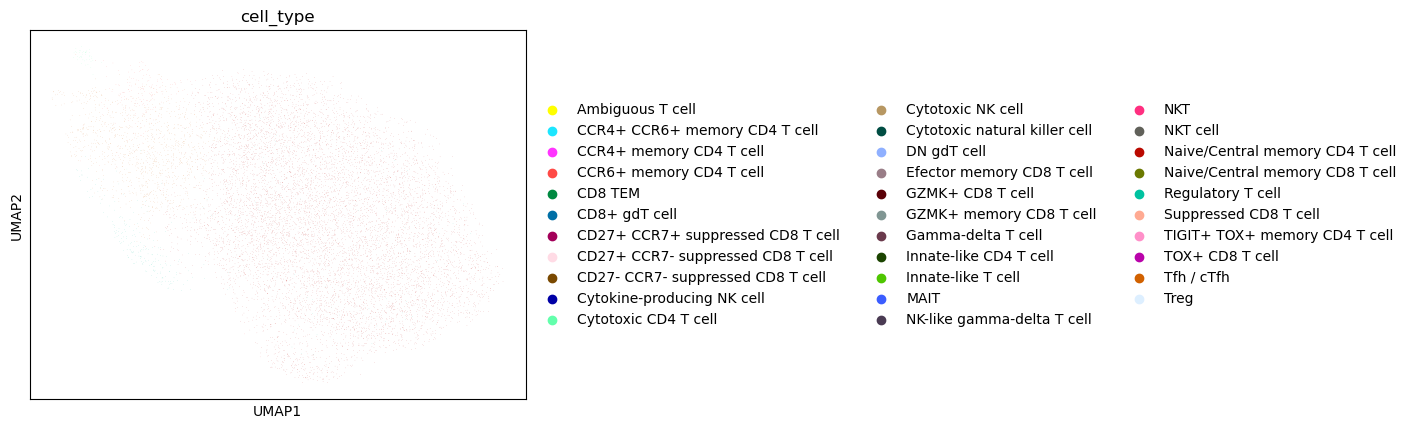

In [ ]:
sc.pl.umap(adata_with_meta, color="cell_type")


In [28]:
adata.obs_names_make_unique()
adata_with_meta.obs[["pica_id", 'Age in years at the time of collection']]

,pica_id,Age in years at the time of collection
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_3_AAACCAGCAATACCCG,PICA0007,3.17
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_3_AAACCCATCATGTAGT,PICA0007,3.17
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_3_AAACCCATCCGATAGC,PICA0007,3.17
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_3_AAACCCATCGTCTCTG,PICA0007,3.17
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_3_AAACCCCAGCTCGATA,PICA0007,3.17
...,...,...
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_2_GTTGTCCGTAGTGTCG,PICA0005,9.30
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_2_GTTGTCCGTGGCATTG,PICA0004,3.46
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_2_GTTGTCCGTGTACCCT,PICA0006,0.14
20240530_WGS_20240530_sc_PICA0001-PICA0007_20240530_WGS_20240530_sc_PICA0001-PICA0007_Pool_2_GTTGTCTTCACACGTA,PICA0004,3.46


In [23]:
adata_with_meta.obs["Age int in years at the time of collection"] = np.ceil(
    adata_with_meta.obs["Age in years at the time of collection"].
    astype(float)
    .astype(int)
)


adata_with_meta.obs["Age int in years at the time of collection"].value_counts().sort_index()


Age int in years at the time of collection
0     17937
1     28752
2     16135
3     40475
4     71960
5      9511
6     10199
7     28274
8      8909
9     29677
10    29196
11    29132
12    30539
13    66936
14    30689
15    26577
16    17714
Name: count, dtype: int64

In [24]:
adata_with_meta.obs['Age in years at the time of collection'].value_counts().sort_index()

Age in years at the time of collection
0.07      9856
0.14      4675
0.83      3406
1.17     10501
1.51      8768
1.91      9483
2.09      6131
2.17     10004
3.13     10800
3.17      5434
3.23      8951
3.30     11549
3.46      3741
4.01      8712
4.46     10317
4.71     10815
4.76     11386
4.80     10715
4.90      9322
4.95     10693
5.91      9511
6.19     10199
7.02      7080
7.34     11988
7.58      9206
8.44      8909
9.30      4930
9.70     24747
10.01     9434
10.40     9211
10.67    10551
11.10     7821
11.69    11632
11.73     9679
12.24     9930
12.72    11545
12.84     9064
13.02    10582
13.24     8189
13.51    11188
13.79    11882
13.80    14203
13.91    10892
14.37    11353
14.66    10498
14.93     8838
15.09     3451
15.34     6923
15.37     6237
15.52     9966
16.05     8958
16.78     8756
Name: count, dtype: int64

In [ ]:
adata.obs_names_make_unique()

age_range = np.arange(0, adata_with_meta.obs["Age int in years at the time of collection"].max() + 1)
age_counts = (
    adata_with_meta.obs["Age int in years at the time of collection"].value_counts().reindex(age_range, fill_value=0))
    
print(age_counts)

In [ ]:
# Define bins and labels
bins = [0, 3, 6, 10, 14, 18]
labels = ["0–3", "4–6", "7–10", "11–14", "15–18"]

# Create new column for grouped ages
adata_with_meta.obs["Age_group"] = pd.cut(
    adata_with_meta.obs["Age_int"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

In [ ]:
adata_with_meta.obs["Age_group"].value_counts().sort_index()

In [ ]:
adata_with_meta.obs["Age_group"].value_counts().sort_index().plot(
    kind="bar", figsize=(6,4), color="lightsteelblue"
)
plt.title("Cell distribution across age groups (0–18 years)")
plt.xlabel("Age group")
plt.ylabel("Cell count")
plt.show()

In [ ]:
meta_df = adata_with_meta.obs[["pica_id", "Age_group"]].drop_duplicates()
meta_df["Age_group"].value_counts().sort_index()

In [ ]:
sc.pl.umap(adata_with_meta, color=["Child's sex", "Age int in years at the time of collection"])

In [ ]:
adata_with_meta.write_h5ad(
    "/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/03_batch_expression/PICA0001-PICA0007_adata_with_age_groups.h5ad"
)